In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from importlib import reload

import models
import plotting
import utils.dataloaders as dl
import traintest as tt
import adversarial as adv
import utils.preproc as pre
import utils.eval as ev

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
class LeNetMadry(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, 1, padding=2)
        self.fc1 = nn.Linear(7*7*64, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 7*7*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [27]:
base_model = torch.load('SavedModels/madry.pth').to(device)
base_model_ACET = torch.load('SavedModels/madry.pth').to(device)
gmm_model = torch.load('SavedModels/gmm_model.pth').to(device)
gmm_model_ACET = torch.load('SavedModels/gmm_model.pth').to(device)

In [90]:
Base_AdversarialNoiseLoader = adv.create_adv_noise_loader(base_model, dl.Noise_loader, device)
Base_AdversarialSampleLoader = adv.create_adv_sample_loader(base_model, dl.MNIST_test_loader, device)

base_loaders = (
[('FMNIST', dl.FMNIST_test_loader), 
 ('EMNIST', dl.EMNIST_test_loader),
 ('GrayCIFAR10', dl.GrayCIFAR10_test_loader),
 ('Noise', dl.Noise_loader),
 ('Adv. Noise', Base_AdversarialNoiseLoader ),
 ('Adv. Sample', Base_AdversarialSampleLoader)]
)

base_df = evaluate_model(base_model, device, dl.MNIST_test_loader, base_loaders)

In [94]:
GMM_AdversarialNoiseLoader = adv.create_adv_noise_loader(gmm_model, dl.Noise_loader, device)
GMM_AdversarialSampleLoader = adv.create_adv_sample_loader(gmm_model, dl.MNIST_test_loader, device)

GMM_loaders = (
[('FMNIST', dl.FMNIST_test_loader), 
 ('EMNIST', dl.EMNIST_test_loader),
 ('GrayCIFAR10', dl.GrayCIFAR10_test_loader),
 ('Noise', dl.Noise_loader),
 ('Adv. Noise', GMM_AdversarialNoiseLoader ),
 ('Adv. Sample', GMM_AdversarialSampleLoader)]
)

gmm_df = evaluate_model(gmm_model, device, dl.MNIST_test_loader, GMM_loaders)

In [102]:
df3 = df.merge(gmm_df, right_index=True, left_index=True, suffixes=("_plain", "_gmm"))

In [28]:
lr = .00001
momentum = .9

optimizer = optim.SGD(base_model_ACET.parameters(), lr=lr, momentum=momentum)
#tt.train_ACET(base_model_ACET, device, dl.MNIST_train_loader, dl.Noise_loader, optimizer_base, 0)

for epoch in range(3):
    optimizer.param_groups[0]['lr'] /= 1.1
    tt.train_ACET(base_model_ACET, device, dl.MNIST_train_loader, dl.Noise_loader, optimizer, epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 1.192976
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.852346
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.115857
Train Epoch: 0 [30000/60000 (50%)]	Loss: 1.029042
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.955626
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.894749
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.962357
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.953286
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.862570
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.819326
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.825107
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.773230
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.842316
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.758830
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.790493
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.807953
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.774516
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.760352


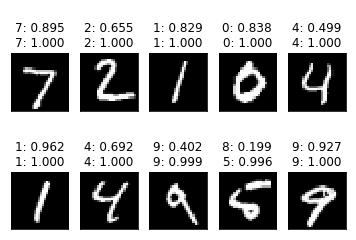

In [30]:
lr = .00001
momentum = .9

optimizer = optim.SGD(gmm_model_ACET.parameters(), lr=lr, momentum=momentum)

for epoch in range(3):
    optimizer.param_groups[0]['lr'] /= 1.1
    tt.train_ACET(gmm_model_ACET, device, dl.MNIST_train_loader, dl.Noise_loader, optimizer, epoch)

In [ ]:
Base_ACET_AdversarialNoiseLoader = adv.create_adv_noise_loader(base_model_ACET, dl.Noise_loader, device)
Base_ACET_AdversarialSampleLoader = adv.create_adv_sample_loader(base_model_ACET, dl.MNIST_test_loader, device)

base_ACET_loaders = (
[('FMNIST', dl.FMNIST_test_loader), 
 ('EMNIST', dl.EMNIST_test_loader),
 ('GrayCIFAR10', dl.GrayCIFAR10_test_loader),
 ('Noise', dl.Noise_loader),
 ('Adv. Noise', Base_ACET_AdversarialNoiseLoader ),
 ('Adv. Sample', Base_ACET_AdversarialSampleLoader)]
)

base_ACET_df = evaluate_model(base_model_ACET, device, dl.MNIST_test_loader, base_ACET_loaders)

In [ ]:
GMM_ACET_AdversarialNoiseLoader = adv.create_adv_noise_loader(gmm_model_ACET, dl.Noise_loader, device)
GMM_ACET_AdversarialSampleLoader = adv.create_adv_sample_loader(gmm_model_ACET, dl.MNIST_test_loader, device)

GMM_ACET_loaders = (
[('FMNIST', dl.FMNIST_test_loader), 
 ('EMNIST', dl.EMNIST_test_loader),
 ('GrayCIFAR10', dl.GrayCIFAR10_test_loader),
 ('Noise', dl.Noise_loader),
 ('Adv. Noise', GMM_ACET_AdversarialNoiseLoader ),
 ('Adv. Sample', GMM_ACET_AdversarialSampleLoader)]
)

gmm_ACET_df = evaluate_model(gmm_model_ACET, device, dl.MNIST_test_loader, GMM_ACET_loaders)